# Epic 5:

Als een key user kan ik voor een campagne een lijst met contacten genereren volgens de waarschijnlijkheid om in te schrijven voor de campagne. Ik wil in de sortering ook ervoor zorgen dat contacten met weinig marketing pressure bevoordeeld worden ten opzichte van contacten met een hoge marketing pressure. 

In [229]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic diagram
import seaborn as sns   

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, MetaData, select
import pandas as pd


## Database connection

In [230]:
load_dotenv()
csv_dir =  '/home/flor/Workspace/DEP2/DataEngineerProj2/Data'
SERVER = os.environ.get('SERVER')
DATABASE = os.environ.get('DATAWAREHOUSE')
UID = os.environ.get('USER') 
PWD = os.environ.get('PASSWORD')

connection_string = f'mssql+pyodbc://{UID}:{PWD}@{SERVER}/{DATABASE}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(connection_string)

metadata = MetaData()
metadata.reflect(engine)

### Creating DataFrame

In [231]:
df_fact = pd.read_sql_table(table_name='FactCampagne', con=engine)
df_mail = pd.read_sql_table(table_name='DimEmail', con=engine)
df_cont = pd.read_sql_table(table_name='DimContact', con=engine)
df_cust = pd.read_sql_table(table_name='DimCustomer', con=engine)
df_date = pd.read_sql_table(table_name='DimDate', con=engine)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

df_final = pd.merge(df_fact, df_mail, on=["Mailing_ID", "Visit_ID", "Campagne_ID", "Contact_ID"])

df_final = pd.merge(df_final, df_cont, on=["Contact_ID","Persoon_ID", "Inschrijving_ID"])

df_final = pd.merge(left=df_final, right=df_cust ,on=["Customer_ID", "Persoon_ID"])

df_final['End_date_campagne'] = df_final['Eind_date_key'].map(df_date.set_index('date_Key')['date'])
df_final['Start_date_campagne'] = df_final['Start_date_key'].map(df_date.set_index('date_Key')['date'])

df_final.rename(columns={"Reden_van_status_x" : "Compleet"}, inplace=True)
df_final.drop("Reden_van_status_y", axis=1, inplace=True)

df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16206 entries, 0 to 16205
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Customer_ID             16206 non-null  object        
 1   Persoon_ID              16206 non-null  object        
 2   Contact_ID              16206 non-null  object        
 3   Inschrijving_ID         16206 non-null  object        
 4   Campagne_ID             16206 non-null  object        
 5   Mailing_ID              16206 non-null  object        
 6   Visit_ID                16206 non-null  object        
 7   Campagne_Nr             16206 non-null  object        
 8   Eind_date_key           16206 non-null  int64         
 9   Naam_Campagne           16206 non-null  object        
 10  Naam_in_email           16206 non-null  object        
 11  Compleet                16206 non-null  object        
 12  Start_date_key          16206 non-null  int64 

In [232]:
df_final.head()

Customer_ID                            Persoon_ID  \
0  E40F33E0-C268-E111-B43A-00505680000A  59586FD2-A913-E211-9DAA-005056B06EB4   
1  E40F33E0-C268-E111-B43A-00505680000A  59586FD2-A913-E211-9DAA-005056B06EB4   
2  E40F33E0-C268-E111-B43A-00505680000A  59586FD2-A913-E211-9DAA-005056B06EB4   
3  E40F33E0-C268-E111-B43A-00505680000A  59586FD2-A913-E211-9DAA-005056B06EB4   
4  E40F33E0-C268-E111-B43A-00505680000A  59586FD2-A913-E211-9DAA-005056B06EB4   

                             Contact_ID                       Inschrijving_ID  \
0  90122280-58FD-E811-80F9-001DD8B72B61  1117EF05-AEE2-ED11-A7C7-6045BD895403   
1  90122280-58FD-E811-80F9-001DD8B72B61  1117EF05-AEE2-ED11-A7C7-6045BD895403   
2  90122280-58FD-E811-80F9-001DD8B72B61  1117EF05-AEE2-ED11-A7C7-6045BD895403   
3  90122280-58FD-E811-80F9-001DD8B72B61  1117EF05-AEE2-ED11-A7C7-6045BD895403   
4  90122280-58FD-E811-80F9-001DD8B72B61  1117EF05-AEE2-ED11-A7C7-6045BD895403   

                            Campagne_ID                            Mailing_ID  \
0  A2F63005-8EA8-ED11-AAD1-6045BD895D85  AD97B2C6-D6D9-ED11-A7C7-6045BD89520A   
1  A2F63005-8EA8-ED11-AAD1-6045BD895D85  AD97B2C6-D6D9-ED11-A7C7-6045BD89520A   
2  A2F63005-8EA8-ED11-AAD1-6045BD895D85  AD97B2C6-D6D9-ED11-A7C7-6045BD89520A   
3  A2F63005-8EA8-ED11-AAD1-6045BD895D85  AD97B2C6-D6D9-ED11-A7C7-6045BD89520A   
4  A2F63005-8EA8-ED11-AAD1-6045BD895D85  AD97B2C6-D6D9-ED11-A7C7-6045BD89520A   

                               Visit_ID    Campagne_Nr  Eind_date_key  \
0  5DAB6B2C-9507-459C-8049-6B2BED9F7D78  23-OV-01-0056       20230525   
1  912DCB29-3C9A-49AB-B216-D540311CA428  23-OV-01-0056       20230525   
2  D7A2B3AC-CD13-4133-AE66-7FB0F4E09FEE  23-OV-01-0056       20230525   
3  CC7E44A6-EDF5-4536-AA39-7692A208A382  23-OV-01-0056       20230525   
4  272243FC-FC22-4EB7-BE46-13FB0EF558CC  23-OV-01-0056       20230525   

           Naam_Campagne                                       Naam_in_email  \
0  OV-NW-Voka Bilan 2023  Voka's statutaire jaarvergadering & jaarfeest 2023   
1  OV-NW-Voka Bilan 2023  Voka's statutaire jaarvergadering & jaarfeest 2023   
2  OV-NW-Voka Bilan 2023  Voka's statutaire jaarvergadering & jaarfeest 2023   
3  OV-NW-Voka Bilan 2023  Voka's statutaire jaarvergadering & jaarfeest 2023   
4  OV-NW-Voka Bilan 2023  Voka's statutaire jaarvergadering & jaarfeest 2023   

   Compleet  Start_date_key Status_Camp     Type_campagne Soort_Campagne  \
0  Voltooid        20230525      Actief  Netwerkevenement        Offline   
1  Voltooid        20230525      Actief  Netwerkevenement        Offline   
2  Voltooid        20230525      Actief  Netwerkevenement        Offline   
3  Voltooid        20230525      Actief  Netwerkevenement        Offline   
4  Voltooid        20230525      Actief  Netwerkevenement        Offline   

  Onderwerp_campagne                Mailing_Name Mailing_Sent_On  \
0                 NW  OV-NW-Bilan 2023-4 kaarten       24-4-2023   
1                 NW  OV-NW-Bilan 2023-4 kaarten       24-4-2023   
2                 NW  OV-NW-Bilan 2023-4 kaarten       24-4-2023   
3                 NW  OV-NW-Bilan 2023-4 kaarten       24-4-2023   
4                 NW  OV-NW-Bilan 2023-4 kaarten       24-4-2023   

                    Mailing_Subject          IP_Stad  IP_Land  \
0  Uitnodiging: Voka Jaarfeest 2023        Oudenburg  Belgium   
1  Uitnodiging: Voka Jaarfeest 2023  Braine-l'Alleud  Belgium   
2  Uitnodiging: Voka Jaarfeest 2023            Uccle  Belgium   
3  Uitnodiging: Voka Jaarfeest 2023        Oudenburg  Belgium   
4  Uitnodiging: Voka Jaarfeest 2023            Uccle  Belgium   

         IP_Adress                       IP_Organization  \
0   84.199.144.185  C5A389AF-4BED-EC11-BB3D-00224885825F   
1  178.144.115.231  C3B89363-4BBB-ED11-83FF-6045BD895D85   
2    37.185.187.18  C309F35C-2BFB-ED11-8849-6045BD895D4D   
3   84.199.144.185  C5A389AF-4BED-EC11-BB3D-00224885825F   
4    37.185.187.18  C309F35C-2BFB-ED11-8849-6045BD895D4D   

                             

In [233]:
import datetime
id_columns = df_final[['Customer_ID', 'Persoon_ID', 'Contact_ID', 'Inschrijving_ID', 'Campagne_ID', 'Mailing_ID', 'Visit_ID', 'Account_ID', "Lidmaatschap_ID"]]
df_final_strip = df_final.drop(id_columns, axis=1)

df_final_strip["Duration"] = df_final_strip["End_date_campagne"] - df_final_strip["Start_date_campagne"]
df_final_strip["Duration"] = df_final_strip["Duration"] + datetime.timedelta(days=1)

df_final_strip.drop([
                     'Campagne_Nr',
                     'Naam_Campagne',
                     'Naam_in_email',
                     'Mailing_Subject',
                     'IP_Organization',
                     'Mailing_Name',
                     'Mailing_Sent_On',
                     'Datum',
                     'IP_Adress',
                     'Voka_Nr_',
                     'Persoonnr',
                     "Eind_date_key",
                     "Start_date_key",
                     "Postcode",
                     "Voka_medewerker",
                     "Compleet",
                     "Status_Camp",
                     "Contact_status",
                     "Is_Voka_entiteit",
                     "Status_Persoon",
                     "Adres_Land",
                     "Status",
                     "Start_Datum",
                     "Oprichtingsdatum",
                     "End_date_campagne",
                     "Start_date_campagne"
                     ], axis=1, inplace=True)





# print(df_final_strip.info())
df_final_strip.head(5)

Type_campagne Soort_Campagne Onderwerp_campagne          IP_Stad  \
0  Netwerkevenement        Offline                 NW        Oudenburg   
1  Netwerkevenement        Offline                 NW  Braine-l'Alleud   
2  Netwerkevenement        Offline                 NW            Uccle   
3  Netwerkevenement        Offline                 NW        Oudenburg   
4  Netwerkevenement        Offline                 NW            Uccle   

   IP_Land             Functie_title Inschrijving_status     Bron  \
0  Belgium  Algemeen Directeur - CEO            Aanwezig  Website   
1  Belgium  Algemeen Directeur - CEO            Aanwezig  Website   
2  Belgium  Algemeen Directeur - CEO            Aanwezig  Website   
3  Belgium  Algemeen Directeur - CEO            Aanwezig  Website   
4  Belgium  Algemeen Directeur - CEO            Aanwezig  Website   

  Facturatie_bedrag Geografische_regio Geografische_subregio  \
0                 0    Oost-Vlaanderen            Oudenaarde   
1                 0    Oost-Vlaanderen            Oudenaarde   
2                 0    Oost-Vlaanderen            Oudenaarde   
3                 0    Oost-Vlaanderen            Oudenaarde   
4                 0    Oost-Vlaanderen            Oudenaarde   

             Plaats Industriezone_Naam_ Ondernemingsaard Ondernemingstype  \
0  WORTEGEM-PETEGEM                None        Productie   Familiebedrijf   
1  WORTEGEM-PETEGEM                None        Productie   Familiebedrijf   
2  WORTEGEM-PETEGEM                None        Productie   Familiebedrijf   
3  WORTEGEM-PETEGEM                None        Productie   Familiebedrijf   
4  WORTEGEM-PETEGEM                None        Productie   Familiebedrijf   

  Primaire_activiteit Marketing_Communicatie Opzeg Reden_Aangroei  \
0                Bouw                 Strikt  None           None   
1                Bouw                 Strikt  None           None   
2                Bouw                 Strikt  None           None   
3                Bouw                 Strikt  None           None   
4                Bouw                 Strikt  None           None   

  Reden_Verloop Duration  
0          None   1 days  
1          None   1 days  
2          None   1 days  
3          None   1 days  
4          None   1 days

## Data Preprocessing


### Handling Text and Categorical Attributes

In [234]:
df_final_strip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16206 entries, 0 to 16205
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Type_campagne           16206 non-null  object         
 1   Soort_Campagne          16206 non-null  object         
 2   Onderwerp_campagne      16206 non-null  object         
 3   IP_Stad                 16166 non-null  object         
 4   IP_Land                 16166 non-null  object         
 5   Functie_title           15755 non-null  object         
 6   Inschrijving_status     16206 non-null  object         
 7   Bron                    16206 non-null  object         
 8   Facturatie_bedrag       16206 non-null  object         
 9   Geografische_regio      16206 non-null  object         
 10  Geografische_subregio   16206 non-null  object         
 11  Plaats                  16206 non-null  object         
 12  Industriezone_Naam_     6281 non

In [235]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df_final_strip["Facturatie_bedrag"] = df_final_strip["Facturatie_bedrag"].str.replace(",", ".").astype(float)

# Separate categorical and numerical columns
cat_attribs = [
    "Type_campagne", "Soort_Campagne", 
    "Onderwerp_campagne", "IP_Stad", "IP_Land", "Functie_title", "Inschrijving_status", "Bron", "Geografische_regio", 
    "Geografische_subregio", "Plaats", "Industriezone_Naam_", 
    "Ondernemingsaard", "Ondernemingstype", "Primaire_activiteit", 
     "Marketing_Communicatie", "Opzeg", 
    "Reden_Aangroei", "Reden_Verloop"
]

num_attribs = ['Facturatie_bedrag']

# Categorical pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("encoder", OrdinalEncoder())
])

# Numerical pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Column transformer
prep = ColumnTransformer([
    ('cat', cat_pipeline, cat_attribs),
    ('num', num_pipeline, num_attribs)
])

# Convert numpy array back to DataFrame
df_final_strip = pd.DataFrame(df_final_strip, columns=cat_attribs + num_attribs)

# Apply transformations
df_final_transformed = prep.fit_transform(df_final_strip)

# Create DataFrame from the transformed data
df_final_transformed = pd.DataFrame(df_final_transformed, columns=cat_attribs + num_attribs)

In [236]:
from sklearn.model_selection import train_test_split

X = df_final_transformed.drop('Inschrijving_status', axis=1)
y = df_final_transformed['Inschrijving_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

# X_train, X_test, y_train, y_test = train_test_split(df_final_transformed, df_final_transformed['Inschrijving_status'], test_size=0.25, random_state=42, shuffle=True, stratify=df_final_transformed['Inschrijving_status'])


## Select and Train a Model

### Random Forest

In [237]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight={0: 10, 1: 9},n_estimators=50,max_depth=10,random_state=42, n_jobs=10)

In [238]:
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 10, 1: 9}, max_depth=10,
                       n_estimators=50, n_jobs=10, random_state=42)

In [239]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

y_pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rfc)
precision = precision_score(y_test, y_pred_rfc)
recall = recall_score(y_test, y_pred_rfc)
f1 = f1_score(y_test, y_pred_rfc)
roc_auc = roc_auc_score(y_test, y_pred_rfc)

print(classification_report(y_test, y_pred_rfc))
print("*"*50)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(X_test.shape)
print("*"*50)
print(sum(y_test==True))
print("*"*50)
matrix = confusion_matrix(y_test, y_pred_rfc)
print(matrix.diagonal()/matrix.sum(axis=1))
print("*"*50)
print(matrix)



              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3945
         1.0       1.00      0.29      0.45       107

    accuracy                           0.98      4052
   macro avg       0.99      0.64      0.72      4052
weighted avg       0.98      0.98      0.98      4052

**************************************************
Accuracy: 0.981243830207305
Precision: 1.0
Recall: 0.2897196261682243
F1 Score: 0.4492753623188406
ROC AUC Score: 0.6448598130841121
(4052, 19)
**************************************************
107
**************************************************
[1.         0.28971963]
**************************************************
[[3945    0]
 [  76   31]]


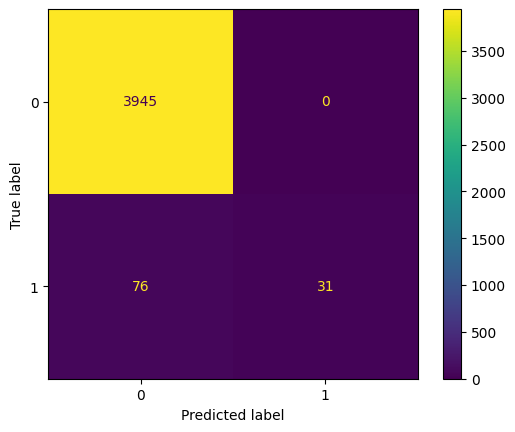

In [240]:
#RFC WITH class weights
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

Grid Search CV, Boosting, Stacking

In [241]:
# from sklearn.model_selection import GridSearchCV

# param = {
#     'class_weight': [{0:x, 1:w} for w in [9,10,11,12,13,14,15] for x in [5,6,7,8,9,10]],
#     'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'max_depth' : [1, 10, 20, 30, 40, 50]
#     }

# grid = GridSearchCV(RandomForestClassifier(random_state=42), param, verbose=True, n_jobs=10)


In [242]:
# grid.fit(X_train, y_train)
# y_pred_grid = grid.predict(X_test)

In [243]:
# print(grid.best_params_)

In [244]:
# print(classification_report(y_test, y_pred_grid))
# ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_grid)).plot()

In [245]:
# X_train.info()

In [246]:
from sklearn.pipeline import make_pipeline
rfc = make_pipeline(prep, RandomForestClassifier(class_weight={0: 0.1, 1: 25},n_estimators=20,max_depth=20,random_state=42, n_jobs=10))

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rfc)
precision = precision_score(y_test, y_pred_rfc)
recall = recall_score(y_test, y_pred_rfc)
f1 = f1_score(y_test, y_pred_rfc)
roc_auc = roc_auc_score(y_test, y_pred_rfc)

print(classification_report(y_test, y_pred_rfc))
print("*"*50)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(X_test.shape)
print("*"*50)
print(sum(y_test==True))
print("*"*50)
matrix = confusion_matrix(y_test, y_pred_rfc)
print(matrix.diagonal()/matrix.sum(axis=1))
print("*"*50)
print(matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, normalize="true", values_format=".0%")
disp.plot()



NameError: name 'rfc' is not defined

In [ ]:
from joblib import dump

dump(rfc, "campagne_rfc.joblib")

['campagne_rfc.joblib']